In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot as plt 
import sklearn
from sklearn.model_selection import train_test_split

## IMPORT & EXPLORE

#### FUNCTIONS

In [2]:
def generate_augmented_images(images, labels, augmentations_per_image=3, zoom_range=(0.9, 1.1)):
    augmented_images = []
    augmented_labels = []

    for img, lbl in zip(images, labels):
        for _ in range(augmentations_per_image):
            # Apply random augmentations
            aug_img = tf.image.random_flip_left_right(img)
            aug_img = tf.image.random_flip_up_down(aug_img)
            aug_img = tf.image.rot90(aug_img, k=np.random.randint(4))
            aug_img = tf.image.random_brightness(aug_img, max_delta=0.1)
            aug_img = tf.image.random_contrast(aug_img, lower=0.8, upper=1.2)

            # Random zoom
            zoom_factor = np.random.uniform(zoom_range[0], zoom_range[1])
            h, w, c = img.shape
            new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)

            if zoom_factor < 1.0:  # Zoom out: pad to original size
                aug_img = tf.image.resize_with_crop_or_pad(aug_img, new_h, new_w)
                aug_img = tf.image.resize(aug_img, (h, w))
            else:  # Zoom in: crop and resize
                aug_img = tf.image.central_crop(aug_img, central_fraction=(1 / zoom_factor))
                aug_img = tf.image.resize(aug_img, (h, w))

            # Append new augmented image and corresponding label
            augmented_images.append(aug_img.numpy())  # Convert to NumPy for consistency
            augmented_labels.append(lbl)

    return np.array(augmented_images), np.array(augmented_labels)

Here , i added zooming , beacuse as practice shows , model performance also depends on that

In [10]:
def display_examples(images, labels, num_examples=5):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        ax.imshow(images[i])  # Display the image
        ax.set_title(f"Label: {labels[i]}")  # Display the label
        ax.axis("off")  # Hide axes
    
    plt.show()

#### IMAGES

In [9]:
lung_xray_scans = np.load(r"C:\Users\User\Desktop\DATA SCIENCE\Projects\XrayCT-Disease-Detection\data\tuberculosis\tuberculosis_detection.npz")['images']
lung_xray_scans_labels = np.load(r"C:\Users\User\Desktop\DATA SCIENCE\Projects\XrayCT-Disease-Detection\data\tuberculosis\tuberculosis_detection.npz")['labels']

## CLEAN & PREPARE

#### PREPARE DATA FOR MODEL BUILDING

In [11]:
lung_xray_scans , lung_xray_scans_labels = generate_augmented_images(images = lung_xray_scans,
                                                                     labels = lung_xray_scans_labels,
                                                                     augmentations_per_image = 3)

In [12]:
lung_xray_scans.shape

(12600, 224, 224, 1)

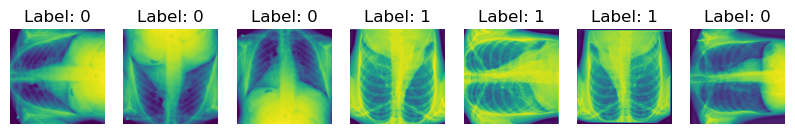

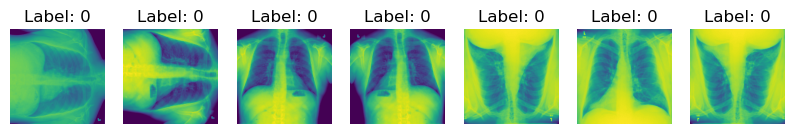

In [13]:
display_examples(images = lung_xray_scans[45:],
                 labels = lung_xray_scans_labels[45:],
                 num_examples=7)

display_examples(images = lung_xray_scans[65:],
                 labels = lung_xray_scans_labels[65:],
                 num_examples=7)

In [16]:
lung_xray_scans_train , lung_xray_scans_test , lung_xray_scans_labels_train , lung_xray_scans_labels_test = train_test_split(
    lung_xray_scans ,
    lung_xray_scans_labels ,
    train_size = 0.95,
    stratify = lung_xray_scans_labels ,
    random_state = 42
)

lung_xray_scans_train , lung_xray_scans_validation , lung_xray_scans_labels_train , lung_xray_scans_labels_validation = train_test_split(
    lung_xray_scans_train ,
    lung_xray_scans_labels_train ,
    train_size = 0.95,
    stratify = lung_xray_scans_labels_train ,
    random_state = 42
)

In [17]:
print(f'IMAGE ARRAYS SHAPES (TRAIN - TEST - VALIDATION) : {lung_xray_scans_train.shape , lung_xray_scans_test.shape , lung_xray_scans_validation.shape }')

IMAGE ARRAYS SHAPES (TRAIN - TEST - VALIDATION) : ((11371, 224, 224, 1), (630, 224, 224, 1), (599, 224, 224, 1))


## MODEL BUILD

In [18]:
from tensorflow.keras import models , layers , optimizers , losses , callbacks 

#### STRUCTURE

In [19]:
lung_xray_scans_sequential_neural_net = models.Sequential( [
   
    layers.Conv2D( filters = 32 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D( filters = 64 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Conv2D( filters = 128 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Conv2D( filters = 256 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization()
    
] )

In [20]:
lung_xray_scans_sequential_neural_net.add( layers.GlobalAveragePooling2D() )

lung_xray_scans_sequential_neural_net.add( layers.Dense( units = 128 ,
                                                         activation = 'relu') )

lung_xray_scans_sequential_neural_net.add( layers.Dropout(rate = 0.5) ) ,

lung_xray_scans_sequential_neural_net.add( layers.Dense( units = 256 ,
                                                         activation = 'relu') ) 

lung_xray_scans_sequential_neural_net.add( layers.Dense( units = 1 ,
                                                         activation = 'sigmoid') )

In [21]:
lung_xray_scans_sequential_neural_net.build( input_shape = (lung_xray_scans.shape) ) 

In [22]:
lung_xray_scans_sequential_neural_net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (12600, 222, 222, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (12600, 111, 111, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (12600, 111, 111, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (12600, 109, 109, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (12600, 54, 54, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (12600, 54, 54, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (12600, 52, 52, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (12600, 26, 26, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (12600, 26, 26, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (12600, 24, 24, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (12600, 12, 12, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (12600, 12, 12, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (12600, 256)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (12600, 128)           │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (12600, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (12600, 256)           │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (12600, 1)             │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 455,937 (1.74 MB)

 Trainable params: 454,977 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

#### COMPILE

In [23]:
lung_xray_scans_sequential_neural_net.compile( optimizer = optimizers.Adam() ,
                                               loss = losses.BinaryCrossentropy(),
                                               metrics = ['accuracy'] )

lung_xray_scans_sequential_neural_net_early_stop = callbacks.EarlyStopping( monitor = 'val_loss',
                                                                            patience = 25 ,
                                                                            restore_best_weights = True )

#### TRAIN

In [29]:
training_history = lung_xray_scans_sequential_neural_net.fit( lung_xray_scans_train,
                                                              lung_xray_scans_labels_train,
                                                              validation_data = [lung_xray_scans_validation,
                                                                                 lung_xray_scans_labels_validation],
                                                              epochs = 120,
                                                              callbacks = [lung_xray_scans_sequential_neural_net_early_stop],
                                                              verbose = 1,
                                                              batch_size = 32 )

Epoch 1/120
  3/213 ━━━━━━━━━━━━━━━━━━━━ 2:09 617ms/step - accuracy: 0.6128 - loss: 0.6546

KeyboardInterrupt: 